In [ ]:
import os, random

import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

## Set fixed ranom seeds to get reproducible results
seed_val = 0
os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
tf.random.set_seed(seed_val)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving angina.csv to angina (3).csv


In [ ]:
#load dataset
df = pd.read_csv('angina.csv')
print(df)

    status  age  smoke  cig  hyper fam ang fam myo fam stroke diabetes
0       no   37      1   15      1      no      no         no       no
1       no   45      3    0      1      no      no         no       no
2      yes   60      3    0      1      no     yes         no       no
3       no   57      3    0      1      no      no         no       no
4      yes   65      1   20      2      no     yes         no       no
..     ...  ...    ...  ...    ...     ...     ...        ...      ...
195     no   58      2    0      3      no      no         no       no
196     no   57      3    0      1      no      no         no       no
197     no   65      1   10      1      no      no         no       no
198    yes   73      1   15      2      no     yes         no       no
199     no   53      3    0      1      no      no         no       no

[200 rows x 9 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   status      200 non-null    object
 1   age         200 non-null    int64 
 2   smoke       200 non-null    int64 
 3   cig         200 non-null    int64 
 4   hyper       200 non-null    int64 
 5   fam ang     200 non-null    object
 6   fam myo     200 non-null    object
 7   fam stroke  200 non-null    object
 8   diabetes    200 non-null    object
dtypes: int64(4), object(5)
memory usage: 14.2+ KB


In [ ]:
df.head()

,status,age,smoke,cig,hyper,fam ang,fam myo,fam stroke,diabetes
0,no,37,1,15,1,no,no,no,no
1,no,45,3,0,1,no,no,no,no
2,yes,60,3,0,1,no,yes,no,no
3,no,57,3,0,1,no,no,no,no
4,yes,65,1,20,2,no,yes,no,no


In [ ]:
df.isnull().sum()

status        0
age           0
smoke         0
cig           0
hyper         0
fam ang       0
fam myo       0
fam stroke    0
diabetes      0
dtype: int64

In [ ]:
def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Levels', 'No. of Levels',
                                    'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]


def return_categoricals(df, threshold=5):
    """
        Returns a list of columns that have less than or equal to
        `threshold` number of unique categorical levels
    """
    return list(filter(lambda c: c if len(df[c].unique()) <= threshold else None,
                       df.columns))

def to_categorical(columns, df):
    """
        Converts the columns passed in `columns` to categorical datatype
    """
    for col in columns:
        df[col] = df[col].astype('category')
    return df

In [ ]:
summarize_categoricals(df, show_levels=True)

,Levels,No. of Levels,No. of Missing Values
status,"[no, yes]",2,0
age,"[37, 45, 60, 57, 65, 56, 42, 52, 61, 59, 49, 3...",39,0
smoke,"[1, 3, 2]",3,0
cig,"[15, 0, 20, 30, 12, 10, 4, 24, 40, 26, 25, 5, ...",17,0
hyper,"[1, 2, 3]",3,0
fam ang,"[no, yes]",2,0
fam myo,"[no, yes]",2,0
fam stroke,"[no, yes]",2,0
diabetes,"[no, yes]",2,0


In [ ]:
to_cast = return_categoricals(df, threshold=5)
df = to_categorical(to_cast, df)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   status      200 non-null    category
 1   age         200 non-null    int64   
 2   smoke       200 non-null    category
 3   cig         200 non-null    int64   
 4   hyper       200 non-null    category
 5   fam ang     200 non-null    category
 6   fam myo     200 non-null    category
 7   fam stroke  200 non-null    category
 8   diabetes    200 non-null    category
dtypes: category(7), int64(2)
memory usage: 5.3 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,200.0,52.445,9.400469,29.0,46.0,53.0,59.00,74.0
cig,200.0,8.205,11.661601,0.0,0.0,0.0,16.25,40.0


In [ ]:
df.dtypes

status        category
age              int64
smoke         category
cig              int64
hyper         category
fam ang       category
fam myo       category
fam stroke    category
diabetes      category
dtype: object

In [ ]:
#cek kolom apa saja yang merupakan data numeric
#random forest hanya bisa mengolah data numeric
num_of_numerical_cols = df._get_numeric_data().columns.shape[0]
print(num_of_numerical_cols, 'numerical columns')
name_of_numerical_cols = df._get_numeric_data().columns
print(name_of_numerical_cols)

2 numerical columns
Index(['age', 'cig'], dtype='object')


In [ ]:
#one-hot encode untuk mengubah data kategorial agar menjadi numerik dengan menambah kolom label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['status'] = label_encoder.fit_transform(df['status'])
df['fam ang'] = label_encoder.fit_transform(df['fam ang'])
df['fam myo'] = label_encoder.fit_transform(df['fam myo'])
df['fam stroke'] = label_encoder.fit_transform(df['fam stroke'])
df['diabetes'] = label_encoder.fit_transform(df['diabetes'])
df

,status,age,smoke,cig,hyper,fam ang,fam myo,fam stroke,diabetes
0,0,37,1,15,1,0,0,0,0
1,0,45,3,0,1,0,0,0,0
2,1,60,3,0,1,0,1,0,0
3,0,57,3,0,1,0,0,0,0
4,1,65,1,20,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...
195,0,58,2,0,3,0,0,0,0
196,0,57,3,0,1,0,0,0,0
197,0,65,1,10,1,0,0,0,0
198,1,73,1,15,2,0,1,0,0


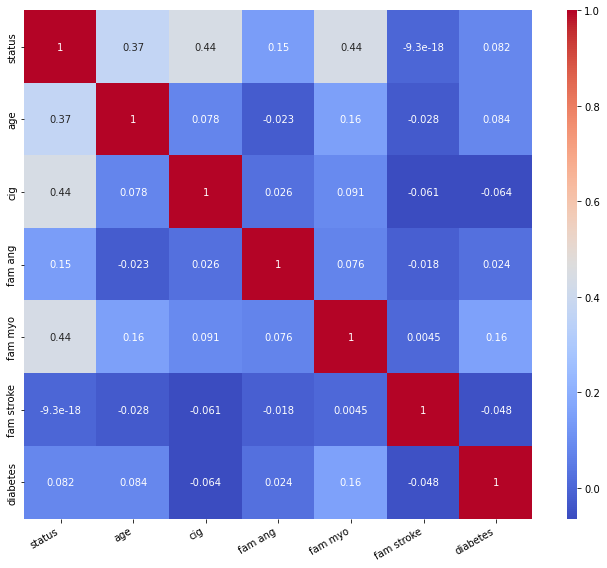

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=df.astype({'status': 'int64'}).corr(),
            annot=True, cmap='coolwarm', cbar_kws={'aspect': 50},
            square=True, ax=ax)
plt.xticks(rotation=30, ha='right');
plt.tight_layout()

In [ ]:
def cramers_corrected_stat(contingency_table):
    """
        Computes corrected Cramer's V statistic for categorial-categorial association
    """
    
    try:
        chi2 = chi2_contingency(contingency_table)[0]
    except ValueError:
        return np.NaN
    
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    
    r, k = contingency_table.shape
    r_corrected = r - (((r-1)**2)/(n-1))
    k_corrected = k - (((k-1)**2)/(n-1))
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    
    return (phi2_corrected / min( (k_corrected-1), (r_corrected-1)))**0.5

In [ ]:
def categorical_corr_matrix(df):
    """
        Computes corrected Cramer's V statistic between all the
        categorical variables in the dataframe
    """
    df = df.select_dtypes(include='category')
    cols = df.columns
    n = len(cols)
    corr_matrix = pd.DataFrame(np.zeros(shape=(n, n)), index=cols, columns=cols)
    
    excluded_cols = list()
    
    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1
                break
            df_crosstab = pd.crosstab(df[col1], df[col2], dropna=False)
            corr_matrix.loc[col1, col2] = cramers_corrected_stat(df_crosstab)
                
    # Flip and add to get full correlation matrix
    corr_matrix += np.tril(corr_matrix, k=-1).T
    return corr_matrix

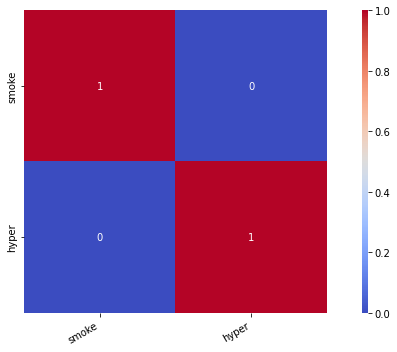

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(categorical_corr_matrix(df), annot=True, cmap='coolwarm', 
            cbar_kws={'aspect': 50}, square=True, ax=ax)
plt.xticks(rotation=30, ha='right');
plt.tight_layout()

In [ ]:
def modified_countplot(**kargs):
    """
        Assumes that columns to be plotted are in of pandas dtype='CategoricalDtype'
    """
    facet_gen = kargs['facet_generator']    ## Facet generator over facet data
    curr_facet, facet_data = None, None
    
    while True:
        ## Keep yielding until non-empty dataframe is found
        curr_facet = next(facet_gen)            ## Yielding facet genenrator
        df_rows = curr_facet[1].shape[0]
        
        ## Skip the current facet if its corresponding dataframe empty
        if df_rows:
            facet_data = curr_facet[1]
            break
    
    x_hue = (kargs.get('x'), kargs.get('hue'))
    cols = [col for col in x_hue if col]
    col_categories = [facet_data[col].dtype.categories if col else None for col in x_hue]
    
    palette = kargs['palette'] if 'palette' in kargs.keys() else 'Pastel2'
    sns.countplot(x=cols[0], hue=x_hue[1], 
                  order=col_categories[0], hue_order=col_categories[1],
                  data=facet_data.loc[:, cols], palette=palette)

In [ ]:
list(df.select_dtypes(include='category'))

['smoke', 'hyper']

In [ ]:
x = df.drop('status', axis = 1)
y = df['status']

categorical_columns = list(x.select_dtypes(include='category').columns)
numeric_columns = list(x.select_dtypes(exclude='category').columns)

In [ ]:
from sklearn.model_selection import train_test_split

data_splits = train_test_split(x, y, test_size=0.3, random_state=seed_val,
                               shuffle=True, stratify=y)
x_train, x_test, y_train, y_test = data_splits

In [ ]:
pd.Series(y_test).value_counts()

1    30
0    30
Name: status, dtype: int64

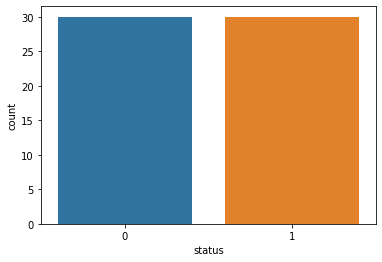

In [ ]:
sns.countplot(x=y_test);

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', dtype=np.int))])

## Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)],
    remainder='passthrough')

## Applying Column Transformer
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)


## Label encoding
y_trans = LabelEncoder()
y_train = y_trans.fit_transform(y_train)
y_test = y_trans.transform(y_test)


## Save feature names after one-hot encoding for feature importances plots
feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'] \
                            .get_feature_names(input_features=categorical_columns))
feature_names = numeric_columns + feature_names

In [ ]:
import timeit
import pickle
import sys
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            precision_recall_curve, roc_curve, accuracy_score
from sklearn.exceptions import NotFittedError

In [ ]:
def confusion_plot(matrix, labels=None):
    """ Display binary confusion matrix as a Seaborn heatmap """
    
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    sns.heatmap(data=matrix, cmap='Blues', annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_title('Confusion Matrix')
    plt.close()
    
    return fig

In [ ]:
def roc_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Receiver Operating Characteristic (ROC) curve 
        Set `compare=True` to use this function to compare classifiers. """
    
    fpr, tpr, thresh = roc_curve(y_true, y_probs, drop_intermediate=False)
    auc = round(roc_auc_score(y_true, y_probs), 2)
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    label = ' '.join([label, f'({auc})']) if compare else None
    sns.lineplot(x=fpr, y=tpr, ax=axis,
                 estimator=None, label=label)
    
    if compare:
        axis.legend(title='Classifier (AUC)', loc='lower right')
    else:
        axis.text(0.72, 0.05, f'AUC = { auc }', fontsize=12,
                  bbox=dict(facecolor='green', alpha=0.4, pad=5))
            
        # Plot No-Info classifier
        axis.fill_between(fpr, fpr, tpr, alpha=0.3, edgecolor='g',
                          linestyle='--', linewidth=2)
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('ROC Curve')
    axis.set_xlabel('False Positive Rate [FPR]\n(1 - Specificity)')
    axis.set_ylabel('True Positive Rate [TPR]\n(Sensitivity or Recall)')
    
    plt.close()
    
    return axis if ax else fig

In [ ]:
def precision_recall_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Precision-Recall curve.
        Set `compare=True` to use this function to compare classifiers. """
    
    p, r, thresh = precision_recall_curve(y_true, y_probs)
    p, r, thresh = list(p), list(r), list(thresh)
    p.pop()
    r.pop()
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    
    if compare:
        sns.lineplot(r, p, estimator=None,
                     ax=axis, label=label)
        axis.set_xlabel('Recall')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')
    else:
        sns.lineplot(thresh, p, estimator=None,
                     label='Precision', ax=axis)
        axis.set_xlabel('Threshold')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')

        axis_twin = axis.twinx()
        sns.lineplot(thresh, r, estimator=None,
                     color='limegreen', label='Recall', ax=axis_twin)
        axis_twin.set_ylabel('Recall')
        axis_twin.set_ylim(0, 1)
        axis_twin.legend(bbox_to_anchor=(0.24, 0.18))
        
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('Precision Vs Recall')
    
    plt.close()
    
    return axis if ax else fig

In [ ]:
def feature_importance_plot(importances, feature_labels, ax=None):
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    sns.barplot(x=importances, y=feature_labels, ax=axis)
    axis.set_title('Feature Importance Measures')
    
    plt.close()
    
    return axis if ax else fig

In [ ]:
def train_clf(clf, x_train, y_train, sample_weight=None, refit=False):
    train_time = 0
    
    try:
        if refit:
            raise NotFittedError
        y_pred_train = clf.predict(x_train)
        
        # For neural nets
        y_pred_train = np.where(y_pred_train.flatten() > 0.5, 1, 0)
        
    except NotFittedError:
        start = timeit.default_timer()
        
        if sample_weight is not None:
            clf.fit(x_train, y_train, sample_weight=sample_weight)
        else:
            clf.fit(x_train, y_train)
        
        end = timeit.default_timer()
        train_time = end - start
        
        y_pred_train = clf.predict(x_train)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    return clf, y_pred_train, train_acc, train_time

In [ ]:
def model_memory_size(clf):
    return sys.getsizeof(pickle.dumps(clf))

In [ ]:
def report(clf, x_train, y_train, x_test, y_test, display_scores=[],
           sample_weight=None, refit=False, importance_plot=False,
           confusion_labels=None, feature_labels=None, neural_net=False,
           verbose=True):
    """ Trains the passed classifier if not already trained and reports
        various metrics of the trained classifier """
    
    dump = dict()
    
    ## Train if not already trained
    clf, train_predictions, \
    train_acc, train_time = train_clf(clf, x_train, y_train,
                                      sample_weight=sample_weight,
                                      refit=refit)
    ## Testing
    start = timeit.default_timer()
    test_predictions = clf.predict(x_test)
    end = timeit.default_timer()
    test_time = end - start

    if neural_net:
        y_probs = np.copy(test_predictions)
        test_predictions = np.where(test_predictions.flatten() > 0.5, 1, 0)
    else:
        y_probs = clf.predict_proba(x_test)[:, 1]
    
    test_acc = accuracy_score(y_test, test_predictions)
    roc_auc = roc_auc_score(y_test, y_probs)
        
    ## Additional scores
    scores_dict = dict()
    for func in display_scores:
        scores_dict[func.__name__] = [func(y_train, train_predictions),
                                      func(y_test, test_predictions)]
        
    ## Model Memory
    model_mem = None
    if not neural_net:
        model_mem = round(model_memory_size(clf) / 1024, 2)

    print(clf)
    print("\n=============================> TRAIN-TEST DETAILS <======================================")
    
    ## Metrics
    print(f"Train Size: {x_train.shape[0]} samples")
    print(f" Test Size: {x_test.shape[0]} samples")
    print("---------------------------------------------")
    print(f"Training Time: {round(train_time, 3)} seconds")
    print(f" Testing Time: {round(test_time, 3)} seconds")
    print("---------------------------------------------")
    print("Train Accuracy: ", train_acc)
    print(" Test Accuracy: ", test_acc)
    print("---------------------------------------------")
    
    if display_scores:
        for k, v in scores_dict.items():
            score_name = ' '.join(map(lambda x: x.title(), k.split('_')))
            print(f'Train {score_name}: ', v[0])
            print(f' Test {score_name}: ', v[1])
            print()
        print("---------------------------------------------")
    
    print(" Area Under ROC (test): ", roc_auc)
    print("---------------------------------------------")
    print(f"Model Memory Size: {model_mem} kB")
    print("\n=============================> CLASSIFICATION REPORT <===================================")
    
    ## Classification Report
    clf_rep = classification_report(y_test, test_predictions, output_dict=True)
    
    print(classification_report(y_test, test_predictions,
                                target_names=confusion_labels))
    
    if verbose:
        print("\n================================> CONFUSION MATRIX <=====================================")
    
        ## Confusion Matrix HeatMap
        display(confusion_plot(confusion_matrix(y_test, test_predictions),
                               labels=confusion_labels))
        print("\n=======================================> PLOTS <=========================================")


        ## Variable importance plot
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        roc_axes = axes[0, 0]
        pr_axes = axes[0, 1]
        importances = None

        if importance_plot:
            if not feature_labels:
                raise RuntimeError("'feature_labels' argument not passed "
                                   "when 'importance_plot' is True")

            try:
              importances = pd.Series(clf.feature_importances_,
                                        index=feature_labels) \
                                .sort_values(ascending=False)
            except AttributeError:
                try:
                    importances = pd.Series(clf.coef_.ravel(),
                                            index=feature_labels) \
                                    .sort_values(ascending=False)
                except AttributeError:
                    pass

            if importances is not None:
                # Modifying grid
                grid_spec = axes[0, 0].get_gridspec()
                for ax in axes[:, 0]:
                    ax.remove()   # remove first column axes
                large_axs = fig.add_subplot(grid_spec[0:, 0])

                 # Plot importance curve
                feature_importance_plot(importances=importances.values,
                                        feature_labels=importances.index,
                                        ax=large_axs)
                large_axs.axvline(x=0)

                # Axis for ROC and PR curve
                roc_axes = axes[0, 1]
                pr_axes = axes[1, 1]
            else:
                # remove second row axes
                for ax in axes[1, :]:
                    ax.remove()
        else:
            # remove second row axes
            for ax in axes[1, :]:
                ax.remove()
        
         ## ROC and Precision-Recall curves
        clf_name = clf.__class__.__name__
        roc_plot(y_test, y_probs, clf_name, ax=roc_axes)
        precision_recall_plot(y_test, y_probs, clf_name, ax=pr_axes)

        fig.subplots_adjust(wspace=5)
        fig.tight_layout()
        display(fig)
    
        ## Dump to report_dict
        dump = dict(clf=clf, accuracy=[train_acc, test_acc], **scores_dict, 
                train_time=train_time, train_predictions=train_predictions, 
                test_time=test_time, test_predictions=test_predictions, 
                test_probs=y_probs, report=clf_rep, roc_auc=roc_auc, model_memory=model_mem)
        return clf, dump

In [ ]:
def compare_models(y_test=None, clf_reports=[], labels=[], score='accuracy'):
    """ Compare evaluation metrics for the True Positive class [1] of 
        binary classifiers passed in the argument and plot ROC and PR curves.
        
        Arguments:
        ---------
        y_test: to plot ROC and Precision-Recall curves
         score: is the name corresponding to the sklearn metrics
        
        Returns:
        -------
        compare_table: pandas DataFrame containing evaluated metrics
                  fig: `matplotlib` figure object with ROC and PR curves """

    
    ## Classifier Labels
    default_names = [rep['clf'].__class__.__name__ for rep in clf_reports]
    clf_names =  labels if len(labels) == len(clf_reports) else default_names

    ## Compare Table
    table = dict()
    index = ['Train ' + score, 'Test ' + score, 'Overfitting', 'Accuracy', 'ROC Area',
             'Precision', 'Recall', 'F1-score', 'Support']
    for i in range(len(clf_reports)):
        scores = [round(i, 3) for i in clf_reports[i][score]]
        
        roc_auc = clf_reports[i]['roc_auc']
        test_acc = clf_reports[i]['accuracy'][1]
        
        # Get metrics of True Positive class from sklearn classification_report
        true_positive_metrics = list(clf_reports[i]['report']["1"].values())
        
        table[clf_names[i]] = scores + [scores[1] < scores[0], test_acc, roc_auc] + \
                              true_positive_metrics
    
    table = pd.DataFrame(data=table, index=index)
    
    
    ## Compare Plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # ROC and Precision-Recall
    for i in range(len(clf_reports)):
        clf_probs = clf_reports[i]['test_probs']
        roc_plot(y_test, clf_probs, label=clf_names[i],
                 compare=True, ax=axes[0])
        precision_recall_plot(y_test, clf_probs, label=clf_names[i],
                              compare=True, ax=axes[1])
    # Plot No-Info classifier
    axes[0].plot([0,1], [0,1], linestyle='--', color='green')
        
    fig.tight_layout()
    plt.close()
    
    return table.T, fig

In [ ]:
from sklearn import metrics
primary_eval_metric = metrics.f1_score

confusion_lbs = ['No', 'Yes']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 140 samples
 Test Size: 60 samples
---------------------------------------------
Training Time: 0.129 seconds
 Testing Time: 0.014 seconds
---------------------------------------------
Train Accuracy:  0.9357142857142857
 Test Accuracy:  0.8166666666666667
---------------------------------------------
Train F1 Score:  0.9323308270676691
 Test F1 Score

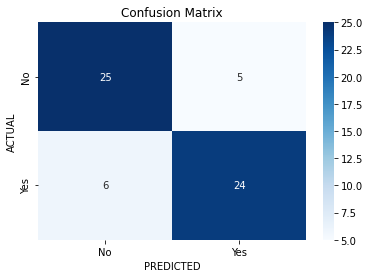


=======================================> PLOTS <=========================================


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


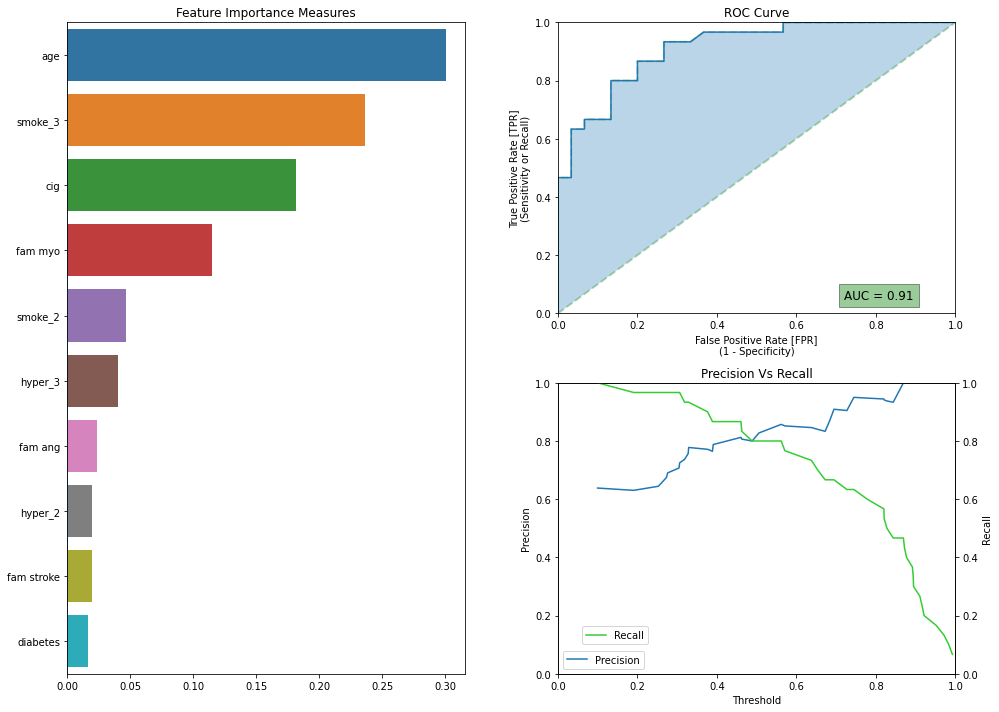

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=5)

random_forest, random_forest_report = report(random_forest, x_train, y_train,
                                             x_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)